# Performance benchmark of the keymark heatpump database

In [1]:
import hplib.hplib_database as db
import hplib.performance as perf
import numpy as np
import pandas as pd

Import the relevant data

In [2]:
performance = db.read_performance_data("performance_data.csv",)
meta = db.read_meta_data("meta_data.csv",)

/home/leander/workspace/fzj/hplib/hplib/hplib_database.py:419: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(OUTPUT_FOLDER_PATH +filename, index_col=[0,1,2], sep=';')


Get the season coefficient of performance and filter temperature 55°C (5) and climate average (3)

In [3]:
scop_55_average = performance.loc[(slice(None), 5, 3), :]
scop_55_average.reset_index(level=['temperature', 'climate'], inplace=True)

Get all heatpumps Outdoor Air as source

In [4]:
air_source_hps = meta[meta['Type'] == 'Outdoor Air/Water'].index
len(air_source_hps)

5053

Determine intersection of union between both indices

In [5]:
reduced_set = air_source_hps.intersection(scop_55_average.index.to_list())
len(reduced_set)

5021

Text(0, 0.5, 'Air source heat pump types')

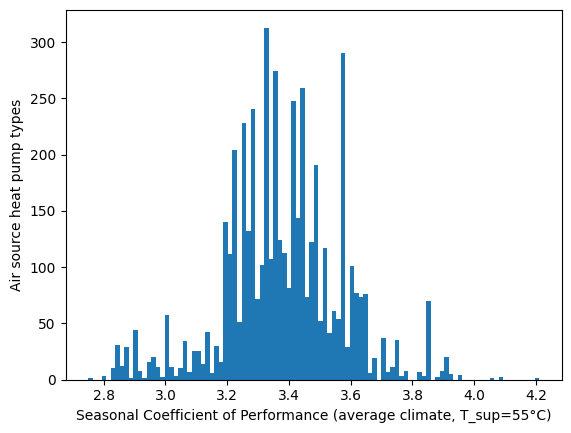

In [6]:
ax = scop_55_average.loc[reduced_set,'scop'].astype(float).plot.hist(bins=100)
ax.set_xlabel("Seasonal Coefficient of Performance (average climate, T_sup=55°C)")
ax.set_ylabel("Air source heat pump types")

## Performance modeling

Get test field

In [7]:
T_sink_s = [35., 55.]
T_source_s = np.linspace(-20, 15, 100)

In [8]:
pf_results = {}
for T_sink in T_sink_s:
    pf_results[T_sink] = pd.DataFrame(index=T_source_s, columns=['Carnot', 'Schwamberger 1991', 'Schlosser et al. 2020', '2nd degree polynomial'])
    for T_source in T_source_s:
        pf_results[T_sink].loc[T_source, 'Carnot'] = perf.cop_carnot(T_source, T_sink)
        pf_results[T_sink].loc[T_source, 'Schwamberger 1991'] = perf.cop_schwamberger(T_source, T_sink)
        pf_results[T_sink].loc[T_source, 'Schlosser et al. 2020'] = perf.cop_schlosser(T_source, T_sink)
        pf_results[T_sink].loc[T_source, '2nd degree polynomial'] = perf.cop_polynomial(T_source, T_sink)
    pf_results[T_sink] = pf_results[T_sink].add_suffix(' $T_{sink}=' + str(T_sink) + '°C$')

And plot results for unfitted parameters

Text(0.5, 0, 'Source temperature $T_{source}$')

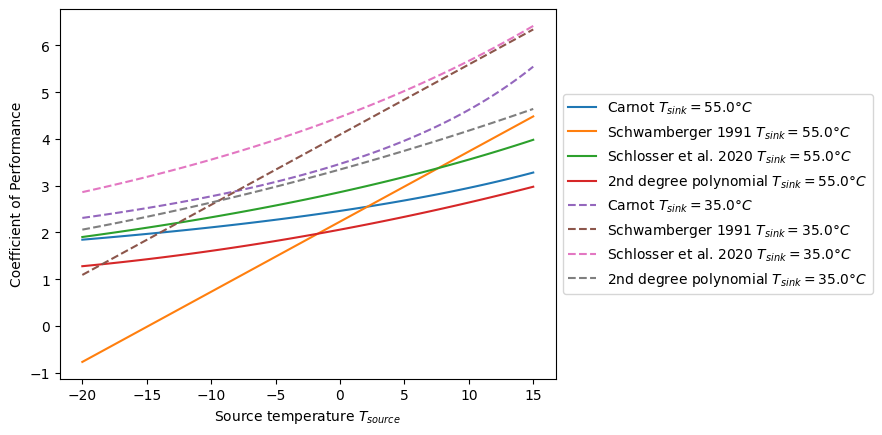

In [9]:
ax = pf_results[55.].plot()
pf_results[35.].plot(ax=ax, style='--')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("Coefficient of Performance")
ax.set_xlabel("Source temperature $T_{source}$")